COVID GDP
==========

This notebook explores the relationship betwen COVID-19 cases and GDP 

# Define general variables

In [1]:
""" Load modules """
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Input data

## Covid incidence and GDP data from Our World in Data

In [2]:
""" Data file """
data_file = 'owd-data-total-covid_19_incidence_gdp_per_capita-20210130.csv'
file_path = '../data/' + data_file

In [3]:
""" Load GDP and covid data """
data = pd.read_csv(file_path)

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
""" Rename data variables """
data.columns = ['country', 'code', 'year', 'continent', 'gdp', 'date', 'incidence', 'notes']

In [5]:
""" Check data """
data.head()

,country,code,year,continent,gdp,date,incidence,notes
0,Abkhazia,OWID_ABK,2015.0,Asia,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,2002.0,NaN,1063.635574,NaN,NaN,NaN
2,Afghanistan,AFG,2003.0,NaN,1099.194507,NaN,NaN,NaN
3,Afghanistan,AFG,2004.0,NaN,1062.249360,NaN,NaN,NaN
4,Afghanistan,AFG,2005.0,NaN,1136.123214,NaN,NaN,NaN


In [6]:
""" Remove entries with no country code (continents and special locations)"""
data.dropna(subset=['code'], inplace=True)

In [7]:
""" Extract DGP per capital data """
gdp_data = data.loc[data.loc[:, 'gdp'].notnull(), ['code', 'year', 'gdp']].copy()
gdp_data.head()

,code,year,gdp
1,AFG,2002.0,1063.635574
2,AFG,2003.0,1099.194507
3,AFG,2004.0,1062.249360
4,AFG,2005.0,1136.123214
5,AFG,2006.0,1161.124889


In [8]:
""" Reshape GDP data by annual value """
gdp_annual = gdp_data.pivot(index='code', columns='year', values='gdp')
gdp_annual.head()

year,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,1998.0,1999.0,...,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0
code,,,,,,,,,,,,,,,,,,,,,
ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,35973.780510,NaN,NaN,NaN,NaN,NaN,NaN
AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1298.143159,1531.173993,1614.255001,1660.739856,1839.273579,1848.700026,1838.960244,1809.016488,1802.695565,1803.987487
AGO,3430.798427,3359.374794,3062.042696,2252.051608,2210.066786,2465.396619,2720.521329,2839.758717,2893.334472,2873.883924,...,5978.323249,5908.042248,5897.682841,5911.254092,5999.902106,6188.003756,6257.152874,6227.664689,5972.451513,5819.494971
ALB,4722.838166,3345.504049,3123.512503,3444.321792,3753.169904,4278.689663,4697.153233,4214.358153,4623.026401,5280.527867,...,9153.788206,9524.649303,9927.181841,10207.764699,10369.823382,10492.806283,10701.120786,10970.452245,11356.341329,11803.430594
ARE,110432.464979,105171.409619,102615.170342,98224.516475,99529.780723,100976.945075,101754.295698,104829.027296,100018.103764,97753.828420,...,71314.668819,60769.861028,57232.618076,58363.678216,59419.089491,61688.380299,63943.185829,66569.403414,67705.949329,67293.482759


In [9]:
""" Extract covid incidence data """
covid_data = data.loc[data.loc[:, 'incidence'].notnull(), ['code', 'date', 'incidence']].copy()
covid_data.head()

,code,date,incidence
17,AFG,2020-02-24,0.026
18,AFG,2020-02-25,0.026
19,AFG,2020-02-26,0.026
20,AFG,2020-02-27,0.026
21,AFG,2020-02-28,0.026


In [10]:
covid_daily = covid_data.pivot(index='code', columns='date', values='incidence')
covid_daily.head()

date,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2021-01-20,2021-01-21,2021-01-22,2021-01-23,2021-01-24,2021-01-25,2021-01-26,2021-01-27,2021-01-28,2021-01-29
code,,,,,,,,,,,,,,,,,,,,,
AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1394.306,1397.517,1399.572,1401.524,1402.449,1404.427,1406.430,1409.102,1410.052,1411.285
AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,580.930,583.486,586.285,589.267,590.240,592.583,594.926,595.748,598.547,600.099
ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24059.351,24294.948,24551.741,24824.866,25114.323,25301.272,25606.713,25911.113,26219.334,26530.683
AND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,120468.517,121387.433,121866.304,122940.529,123587.653,124195.949,124739.533,125749.045,126564.421,127315.084
ARE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.404,0.404,0.404,...,26665.150,27021.961,27381.097,27741.648,28103.515,28466.594,28830.684,29228.949,29629.944,30030.535


In [11]:
""" Select latest date with no missing data """
covid_daily.loc[:, ~covid_daily.isnull().any()].describe()

date,2021-01-21,2021-01-22,2021-01-23,2021-01-24,2021-01-25,2021-01-26,2021-01-27,2021-01-28
count,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000
mean,18838.067267,18976.196550,19094.119168,19182.097487,19292.338681,19406.046136,19541.387932,19669.637052
std,23070.675136,23219.259909,23358.244565,23453.069716,23582.398321,23721.507584,23889.491624,24049.970599
min,3.256000,3.256000,3.256000,3.256000,3.256000,3.256000,3.256000,3.256000
25%,1069.579500,1070.569500,1097.825500,1099.197000,1101.977000,1102.129500,1116.565000,1125.558500
50%,8357.625000,8537.603000,8589.737000,8607.710000,8784.564000,8784.564000,8784.564000,9054.590000
75%,31867.011000,32216.925000,32458.150500,32761.152000,32820.265500,33102.265000,33394.651500,33580.013500
max,121387.433000,121866.304000,122940.529000,123587.653000,124195.949000,124739.533000,125749.045000,126564.421000


From this data, it seems that all countries have been touched by covid since January 21, 2021. To be further investigated with plot

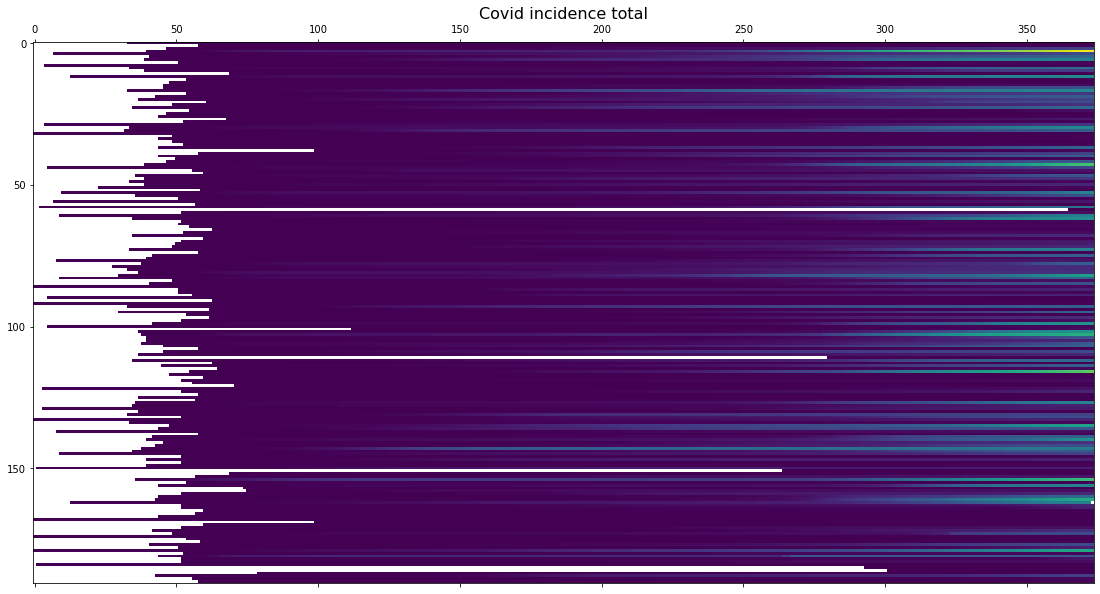

In [105]:
df = covid_daily

f = plt.figure(figsize=(19, 15))
plt.matshow(df, fignum=f.number)
#plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
#plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
#cb = plt.colorbar()
#cb.ax.tick_params(labelsize=14)
plt.title('Covid incidence total', fontsize=16);

In [12]:
""" Check which country was last to declare covid-19 cases """
covid_daily.loc[covid_daily.loc[:, '2021-01-20'].isnull()]

date,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2021-01-20,2021-01-21,2021-01-22,2021-01-23,2021-01-24,2021-01-25,2021-01-26,2021-01-27,2021-01-28,2021-01-29
code,,,,,,,,,,,,,,,,,,,,,
FSM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,8.694,8.694,8.694,8.694,8.694,8.694,8.694,8.694,8.694


On January 20, 2021, the Federal States of Micronesia was the last state to publically declare existing cases of COVID-19 on its territory.

In [13]:
covid_latest = covid_daily.loc[:, '2021-01-28']
covid_latest = np.log(covid_latest)

In [14]:
gdp_latest = gdp_annual.loc[:, 2015]

In [15]:
gdp_latest = np.log(gdp_latest)

In [16]:
""" Continent data """
continents = data.loc[:, ['code', 'continent']].dropna().set_index('code')
continents.head()

,continent
code,
OWID_ABK,Asia
AFG,Asia
OWID_AKD,Asia
ALB,Europe
DZA,Africa


<AxesSubplot:xlabel='2015.0', ylabel='2021-01-28'>

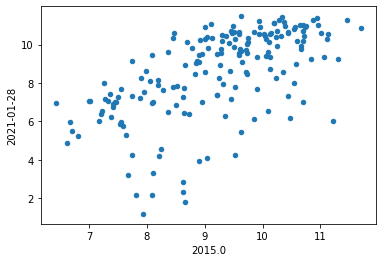

In [17]:
regression_data = pd.concat([gdp_latest, covid_latest, continents], axis=1)

regression_data.plot.scatter(x=2015.0, y='2021-01-28')

In [18]:
regression_data = regression_data.dropna(axis=0)
regression_data.head().dropna(inplace=True)

<ipython-input-18-a76e2422ca80>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regression_data.head().dropna(inplace=True)


### Regressions

In [168]:
x = np.array(plot_data.loc[:, '2021-01-28']).reshape((-1, 1))
y = np.array(plot_data.loc[:, 2015])

In [157]:
model = LinearRegression()

In [158]:
model.fit(x, y)

LinearRegression()

In [159]:
model = LinearRegression().fit(x, y)

In [160]:
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.3662771567994322


In [161]:
print('intercept:', model.intercept_)
print('slope:', model.coef_)

intercept: 6.532241934424281
slope: [0.31388156]


In [163]:
""" Polynomial regression """
transformer = PolynomialFeatures(degree=2, include_bias=False)
transformer.fit(x)
x_ = transformer.transform(x)
print(x_)

[[  7.25138186  52.58253891]
 [  6.39450505  40.88969485]
 [ 10.17425236 103.51541101]
 [ 10.29654075 106.01875143]
 [ 10.64926395 113.40682262]
 [ 10.93748384 119.62855278]
 [  7.69416099  59.20011335]
 [  7.02942232  49.41277812]
 [ 10.72653782 115.05861367]
 [ 10.02852757 100.57136523]
 [  4.89194184  23.93109501]
 [ 11.01220146 121.26858109]
 [  5.74394505  32.99290476]
 [  6.20744047  38.53231722]
 [  8.08400184  65.35108573]
 [ 10.35177639 107.15927452]
 [ 10.99628463 120.91827571]
 [  9.94043679  98.81228365]
 [ 10.51705599 110.60846676]
 [ 10.15426047 103.10900576]
 [ 10.3019171  106.12949598]
 [  9.80103303  96.06024851]
 [ 10.66001323 113.63588207]
 [  8.54474941  73.01274243]
 [  6.01967535  36.23649137]
 [  7.01271151  49.17812276]
 [  9.11102709  83.01081464]
 [  6.93858803  48.1440038 ]
 [  9.92392248  98.48423739]
 [ 11.00234423 121.05157851]
 [ 10.52830188 110.84514039]
 [  4.23845934  17.96453754]
 [  6.9564302   48.39192111]
 [  7.01723012  49.24151855]
 [  5.51840425

In [164]:
model = LinearRegression().fit(x_, y)

In [165]:
r_sq = model.score(x_, y)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('coefficients:', model.coef_)

coefficient of determination: 0.43642753640634546
intercept: 8.889618887181003
coefficients: [-0.40970604  0.04895191]


## Plot scatter of GDP / COVID and polynomial regression model

In [20]:
""" Generate subplot data (continents) """
subplot_data = {}

for continent in regression_data['continent'].unique():
    subplot_data[continent] = regression_data.loc[regression_data.loc[:, 'continent']==continent]

In [38]:
def plot_model(data, scatter, label, ax):
    """ 
    Plot regression model and data scatter
    """
    x = np.array(data.loc[:, 2015.0])
    y = np.array(data.loc[:, '2021-01-28'])
    mymodel = np.poly1d(np.polyfit(x, y, 1))
    vmin, vmax = x.min()-.2, x.max()+.2
    myline = np.linspace(vmin, vmax, 100)
    
    if scatter == True:
        ax.scatter(x, y)
    else:
        pass
    
    if label == True:
        for i, txt in enumerate(data.index):
            ax.annotate(txt, (x[i], y[i]))
    
    plt.plot(myline, mymodel(myline))

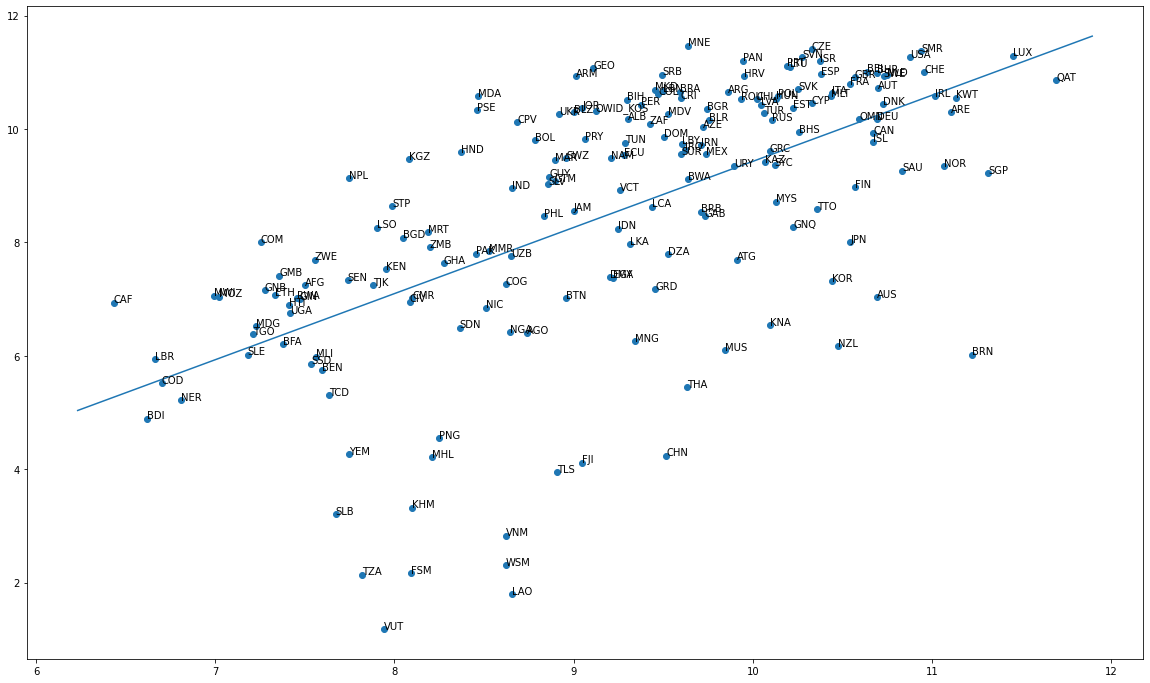

In [39]:
fig, ax = plt.subplots(figsize=(20, 12))

# Plost model on world set
plot_model(regression_data, scatter=True, label=True,  ax=ax)

plt.show()

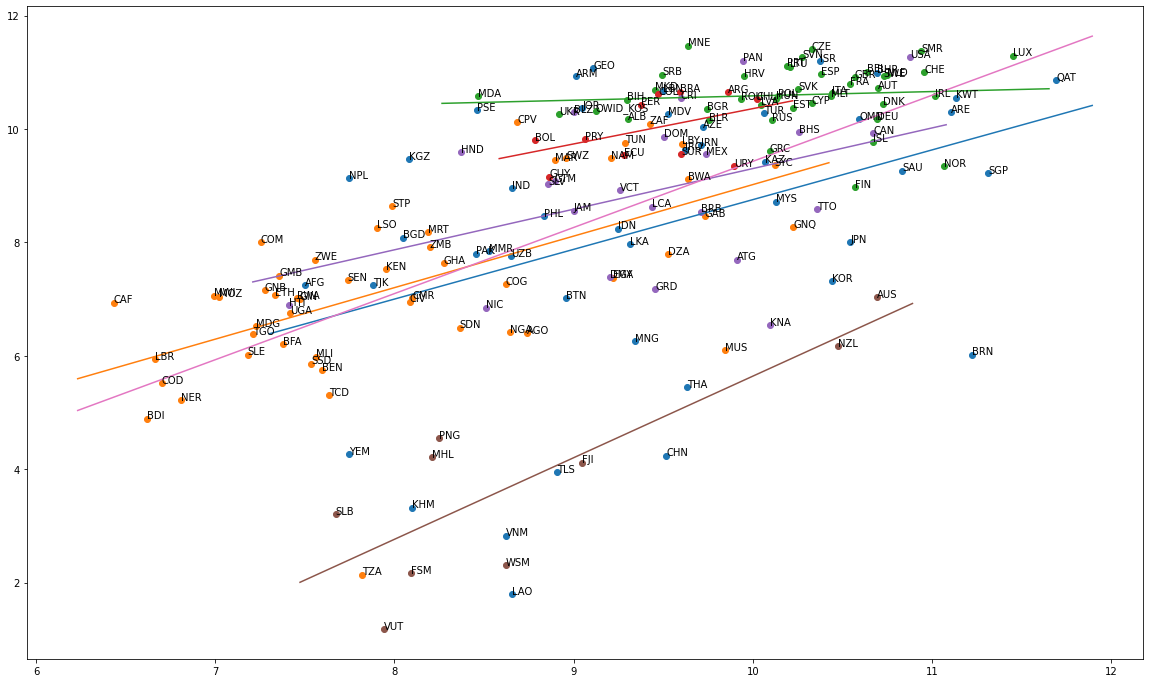

In [42]:
fig, ax = plt.subplots(figsize=(20, 12))

# Plot model on continental sets
for continent in subplot_data:
    df = subplot_data[continent]
    plot_model(df, scatter=True, label=True, ax=ax)
        
# Plot model on world set
plot_model(regression_data, scatter=False, label=False, ax=ax)

plt.show()

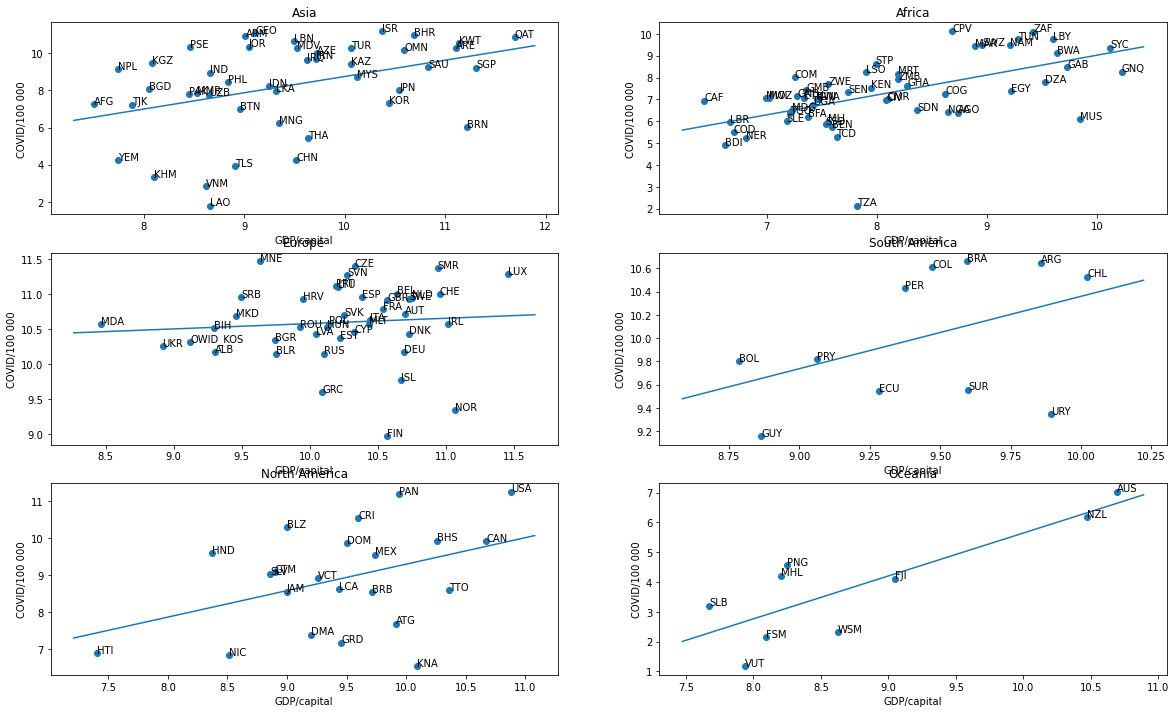

In [60]:
""" Plot continental models """
# Define ax locations
ax_locs = [[0,0], [0, 1], [1, 0], [1, 1], [2, 0], [2, 1]]

fig, axs = plt.subplots(3, 2, figsize=(20, 12))

for i, continent in enumerate(subplot_data.keys()):
    ax = plt.subplot(axs[ax_locs[i][0], ax_locs[i][1]])
    data = subplot_data[continent]   
    plot_model(data, scatter=True, label=True, ax=ax)
    ax.set(title=continent, xlabel='GDP/capital', ylabel='COVID/100 000')

plt.show()